In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [23]:
# Load auction data
auction_data = pd.read_csv('D:/Projects/Flask_Auction_System/datasets/auction_data.csv')

print(auction_data.columns)

# Handle Missing Columns
missing_columns = ['seller_rating', 'buyer_region']
for col in missing_columns:
    if col not in auction_data.columns:
        auction_data[col] = 0

# Convert Categorical Columns
encoder = LabelEncoder()
if 'category' in auction_data.columns and auction_data['category'].dtype == 'object':
    auction_data['category'] = encoder.fit_transform(auction_data['category'])
if 'buyer_region' in auction_data.columns and auction_data['buyer_region'].dtype == 'object':
    auction_data['buyer_region'] = encoder.fit_transform(auction_data['buyer_region'])

duplicates = auction_data.duplicated().sum()
print(f"Duplicates Found: {duplicates}")

# Remove Duplicates
auction_data = auction_data.drop_duplicates()

# Drop Non-Numeric Columns
auction_data = auction_data.select_dtypes(include=[np.number])

# Shuffle Data
auction_data = shuffle(auction_data, random_state=42)

# Fill Missing Values
auction_data = auction_data.fillna(0)

# Feature Selection
X = auction_data[['starting_price', 'bids_count', 'seller_rating']]
y = auction_data['final_price']

# Split Dataset into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate the Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print("Mean Absolute Error:", mae)
# print("Mean Squared Error:", mse)
print("R2 Score:", r2)

with open('final_price_prediction.pkl', 'wb') as file:
    pickle.dump(model, file)

# Prediction Function
def predict_final_price(data):
    with open('price_prediction_prediction.pkl', 'rb') as file:
        model = pickle.load(file)
    input_data = np.array([[data['starting_price'], data['bids_count'], data['auction_duration'], data['seller_rating']]])
    prediction = model.predict(input_data)
    return prediction[0]

Index(['item_id', 'item_name', 'category', 'item_condition', 'starting_price',
       'final_price', 'bids_count', 'auction_duration', 'status',
       'predicted_final_price', 'seller'],
      dtype='object')
Duplicates Found: 0
R2 Score: 0.7010395980603137


Numeric Columns:  Index(['item_id', 'category', 'starting_price', 'final_price', 'bids_count',
       'predicted_final_price', 'seller_rating', 'buyer_region'],
      dtype='object')


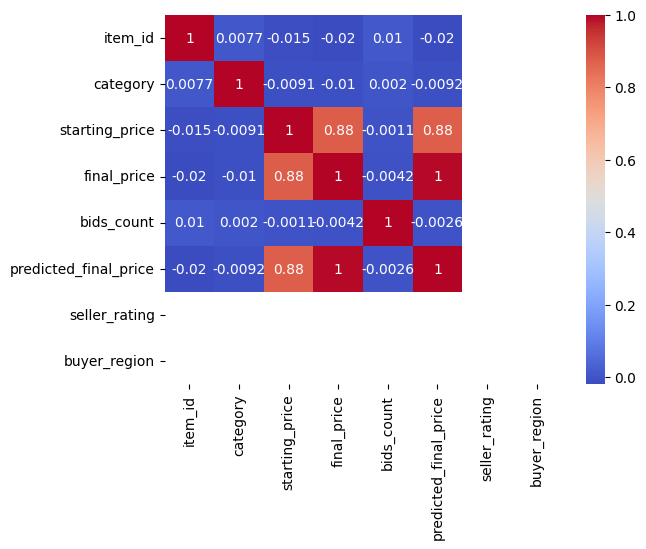

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_columns = auction_data.select_dtypes(include=[np.number])

# Check if any numeric columns exist
print("Numeric Columns: ", numeric_columns.columns)

# Correlation Matrix
corr = numeric_columns.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

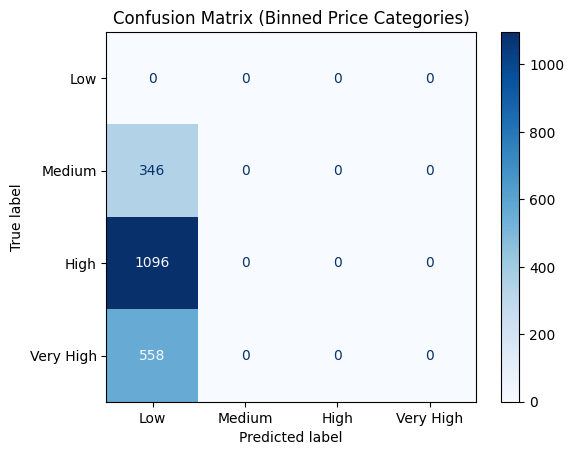

In [25]:
# Load and preprocess your dataset as in the notebook
# Assuming auction_data is already cleaned and processed
X = auction_data[['starting_price', 'bids_count', 'seller_rating']]
y = auction_data['final_price']

# 🔹 Convert continuous prices into categories (bins)
# You can customize the number of bins and labels
bins = [0, 100, 500, 1000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
y_binned = pd.cut(y, bins=bins, labels=labels)

# Split the dataset
X_train, X_test, y_train_binned, y_test_binned = train_test_split(X, y_binned, test_size=0.2, random_state=42)

# Train the regression model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train_binned.cat.codes)  # encode target as integer

# Predict and bin the predictions
y_pred = model.predict(X_test)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Create the confusion matrix
cm = confusion_matrix(y_test_binned, y_pred_binned, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Binned Price Categories)")
plt.show()